# 图像处理——图形验证码识别

- 时间7.26 16:30\-17:30，地点26楼【C语言】会议室
- 形式与时间分配：30分钟简要讲述背景与应用，30分钟实践与问题讨论
- 涉及的技术：图像处理、相关系数、聚类、矩阵操作、数据可视化等
- 所需环境：`Python3`, `Jupyter Notebook`(其他工具包可以现场装)

## 项目背景 
- 爬虫经常遇到
- 常用算法
    - 复杂验证码：深度学习（基于神经网络）
    - 简单验证码：[模板匹配](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html)
<img src="./images/Captcha_ML.png" align="center" style="width:35%" />    

### Machine Learning问题解决的层级
- 面对问题知道该调哪个包（看demo即可）
- 知道怎么如何调参能够改进模型的表现（读文档）
- 理解背后的算法（需要花时间do the math）
- 能够扩展、优化和改进当前的库函数（Expert）

### 采集样本数据

通过`curl`命令获取单张[验证码图片](http://cprp.nmpa.gov.cn/captcha.svl)

In [1]:
# ! curl 'http://cprp.nmpa.gov.cn/captcha.svl' \
# -H 'User-Agent: Mozilla/5.0 (Macintosh;Intel Mac OS X 10_13_6)' \
# >> images/captcha.jpg

批量采集样本图片，并保存到`captcha`路径下
- 训练数据(sample)
- 验证数据(validate)

In [2]:
# !mkdir captcha

In [3]:
# %%bash
# counter=1
# while [ $counter -le 50 ]
# do
#     curl 'http://cprp.nmpa.gov.cn/captcha.svl' \
#         -H 'User-Agent: Mozilla/5.0 (Macintosh;Intel Mac OS X 10_13_6)' \
#         --compressed >> captcha/sample$counter.jpg
#   ((counter++))
# done

### 预处理：随机选取图片进行可视化

In [15]:
import cv2, pickle
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from glob import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'
from sklearn.cluster import KMeans

In [5]:
samples = glob('captcha/sample*.jpg')
n_samples = len(samples)

随机选取部分图片进行观察

In [6]:
X = np.array(list(map(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)/255, samples)))

In [7]:
X.shape

(50, 180, 300, 3)

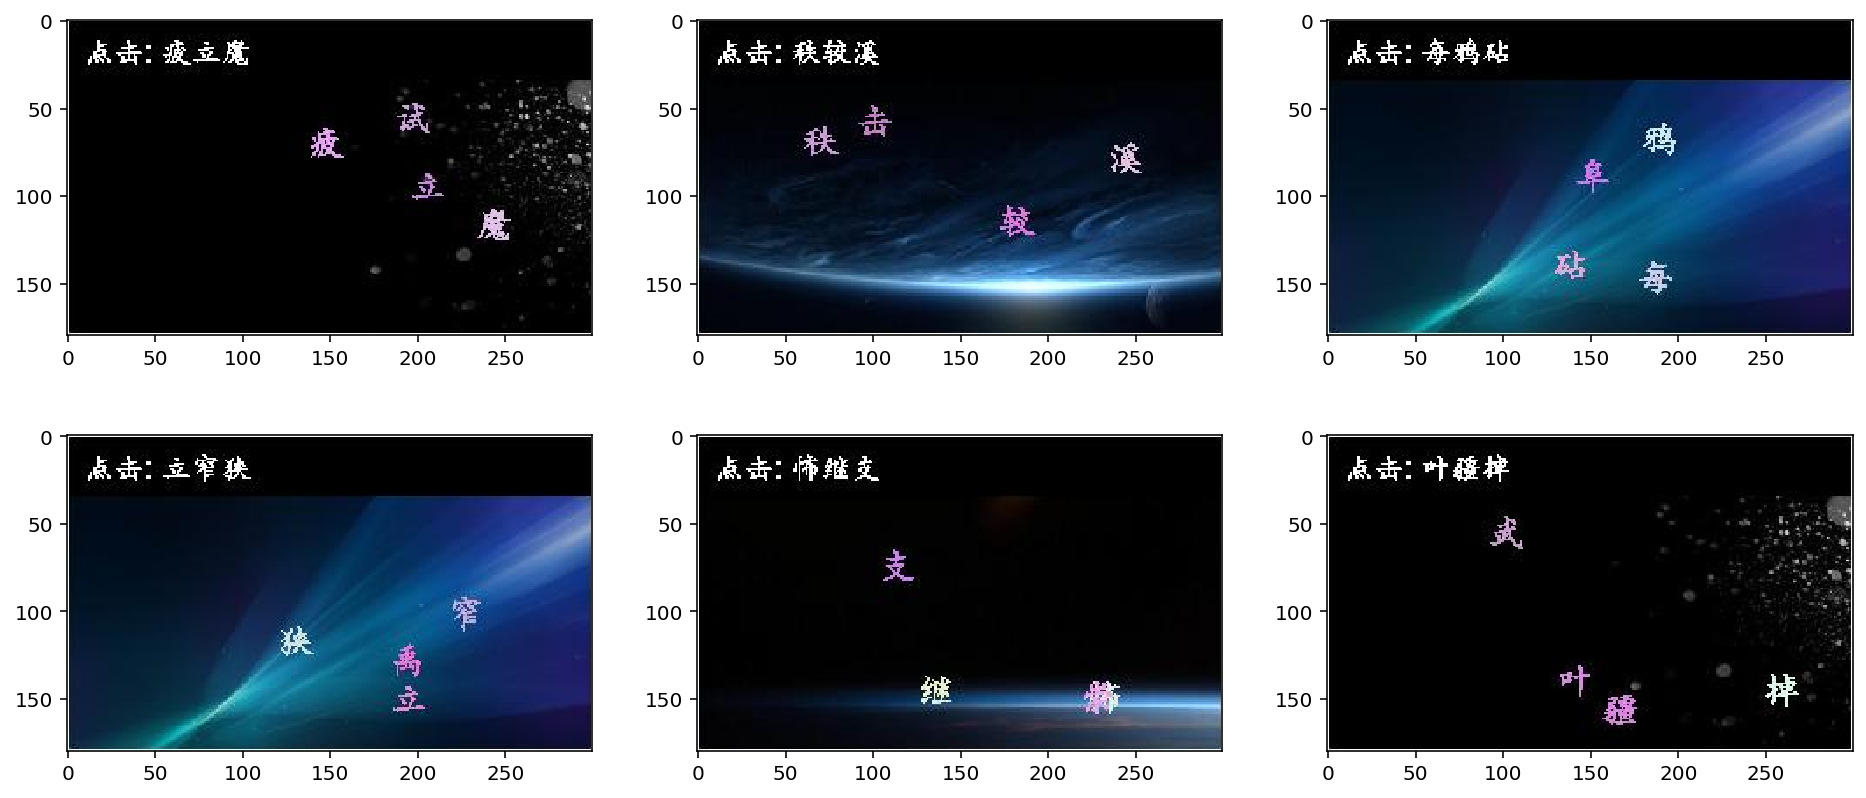

In [8]:
nrows=2
ncols=3
fig, ax = plt.subplots(nrows, ncols, figsize=(16,7))
for index in range(nrows*ncols):
    img = X[np.random.choice(np.arange(n_samples))]
    ax[index//ncols][index%ncols].imshow(img)

### KMeans聚类分离背景图片

In [9]:
X.shape

(50, 180, 300, 3)

In [10]:
rows, cols = original_shape = X[0].shape[:2]
original_size = X[0].size
original_shape, original_size

((180, 300), 162000)

### 训练模型
- 这里需要思考哪些模型适用于当前的问题
- 如何选定K值（聚类中心个数）？

In [17]:
# 修改这部分代码完成模型训练
model = KMeans(n_clusters=4, n_jobs=-1).fit(X.reshape(X.shape[0], original_size))

调用已经训练好的模型

In [18]:
# model = pickle.load(open('KMeans_captcha_model.p', 'rb'))

In [19]:
model.cluster_centers_.shape

(4, 162000)

### 根据聚类中心分离背景图模板

In [20]:
top_margin = 30
backgrounds = []
for i in range(4):
    backgrounds.append(np.median(X[model.labels_==i], axis=0)[top_margin:])

In [21]:
bg_size = backgrounds[0].size

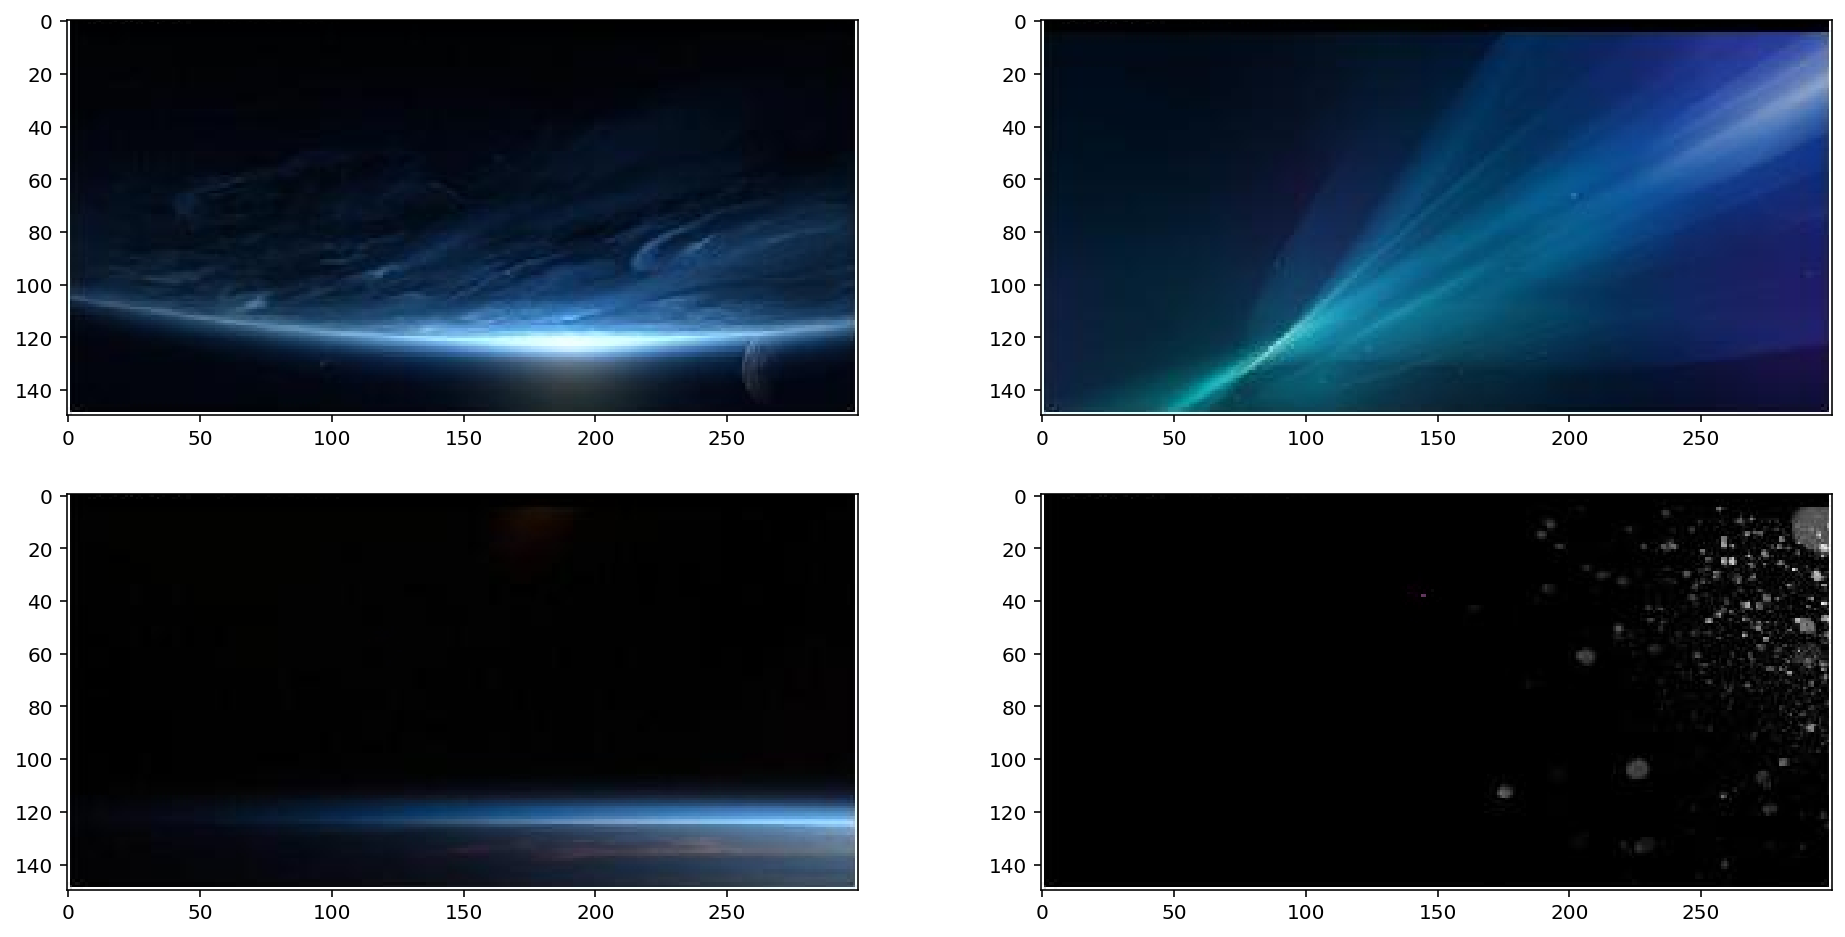

In [22]:
nrows, ncols = (2, 2)
fig, ax = plt.subplots(nrows, ncols, figsize=(16, 8))
for index, img in enumerate(backgrounds):
    ax[index//ncols][index%ncols].imshow(img)

In [23]:
validate_img = cv2.cvtColor(cv2.imread('captcha/sample1.jpg'), cv2.COLOR_BGR2RGB)
template_index = model.predict(validate_img.reshape(1, original_size)/255)[0]
template_matched = np.array(backgrounds[template_index]*255, dtype=np.uint8)

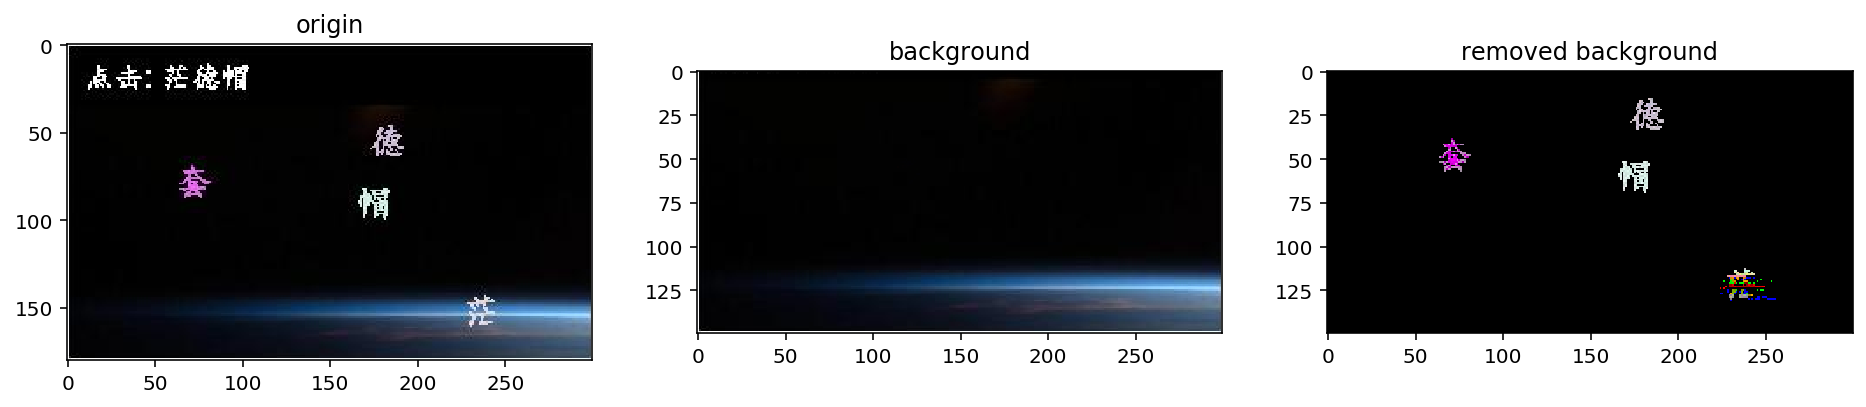

In [24]:
diff = cv2.bitwise_xor(validate_img[top_margin:], template_matched)
# 设定阈值，降低噪音的影响
diff = (diff>127)*diff

fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[0].imshow(validate_img);
ax[0].set_title('origin');
ax[1].imshow(template_matched);
ax[1].set_title('background');
ax[2].imshow(diff);
ax[2].set_title('removed background');

In [25]:
w_text, h_text = 17, 16    
def get_chars_from_image(img):
    row0 = 11
    col0 = 54
    characters = list(map(lambda x:img[row0:row0+h_text, col0+x*w_text:col0+(x+1)*w_text], range(3)))
    return characters

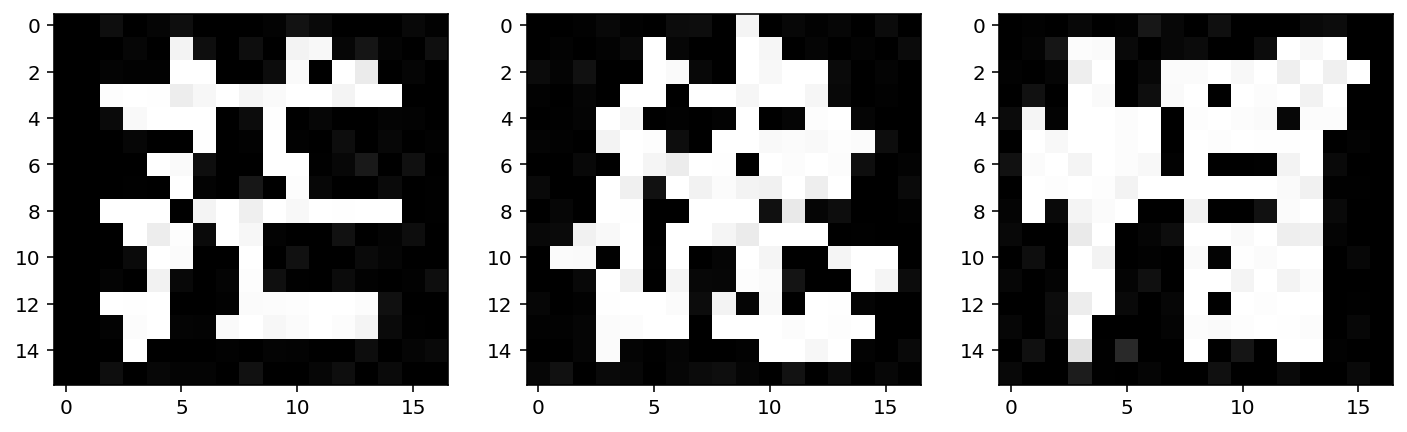

In [26]:
characters = get_chars_from_image(validate_img)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax[i].imshow(characters[i], cmap='gray');

In [27]:
def rgb_2_binary_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

In [30]:
@interact(
    img_index=widgets.IntText(value=1),
    char_index=widgets.IntText(value=0),
)
def view_detection(char_index=0, img_index=0):
    global samples
    validate_img = cv2.cvtColor(cv2.imread('captcha/sample%s.jpg' %(img_index+1)), cv2.COLOR_BGR2RGB)
    chars = get_chars_from_image(validate_img)
    
    template_index = model.predict(validate_img.reshape(1, original_size)/255)[0]
    template_matched = np.array(backgrounds[template_index]*255, dtype=np.uint8)
    
    diff = cv2.bitwise_xor(validate_img[top_margin:], template_matched)
    diff_binary_gray = rgb_2_binary_gray(diff)
    correlation_array = cv2.matchTemplate(rgb_2_binary_gray(chars[char_index]), diff_binary_gray, method=cv2.TM_CCORR)
    position = np.unravel_index(correlation_array.argmax(), correlation_array.shape)

    fig, ax = plt.subplots(1,3, figsize=(16,7))
    ax[0].imshow(diff_binary_gray, cmap='gray')
    ax[1].imshow(correlation_array, cmap='gray');
#     ax[1].scatter(position[1], position[0], c='r', s=40);
    ax[2].imshow(validate_img);
    ax[2].scatter(position[1] + h_text//2, position[0] + top_margin + w_text//2, c='r', s=60);
    
    return

interactive(children=(IntText(value=0, description='char_index'), IntText(value=1, description='img_index'), O…

### Session and Discussion
Session: 补全[模型训练的代码](#训练模型)
- 如何提升识别的准确率？
    - 数据角度
    - 算法角度
- 这种模板匹配的算法有哪些局限性？
- 如果模板种类很多，模型训练时间过长，如何改进训练模型的效率？